In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *

/Users/andrewshaw/miniconda3/envs/midi/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Predictions

### Load Pretrained

In [4]:
# Config
config = default_config()

# Location of your midi files
midi_path =  Path('data/midi/examples')

# Location of saved datset
data_path = Path('data/numpy')
data_save_name = 'musicitem_data_save.pkl'

In [5]:
# Data
data = load_data(data_path, data_save_name)
vocab = data.vocab

/Users/andrewshaw/miniconda3/envs/midi/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [6]:
# Pretrained Model
# Download pretrained model if you haven't already
pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained'
pretrained_path = untar_data(pretrained_url, dest=data_path)
load_path = pretrained_path/'MusicTransformer.pth'; load_path

PosixPath('data/numpy/pretrained/MusicTransformer.pth')

In [9]:
# Learner
learn = music_model_learner(data, config=config.copy(), pretrained_path=load_path)

## Load Exising Song

#### Choose existing midi file as a starting point

In [10]:
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files[:4]

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Scary Monsters And Nice Sprites - Skrillex - Pre-Chorus.mid'),
 PosixPath('data/midi/examples/Can You Feel The Love Tonight - Elton John - Verse.mid'),
 PosixPath('data/midi/examples/Locked Out Of Heaven - Bruno Mars - Chorus.mid')]

In [11]:
idx = 0
f = midi_files[idx]; f

PosixPath('data/midi/examples/Levels - Avicii - Verse.mid')

#### Trim Song

Trim the song to only a few notes. Model will use these notes a seed and continue the idea

In [12]:
cutoff_beat = 5

item = MusicItem.from_file(f, data.vocab)
seed_item = item.trim_to_beat(cutoff_beat)

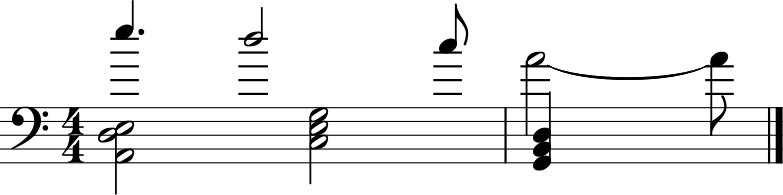

In [13]:
seed_item.show()

In [14]:
seed_item.play()

### Sampling

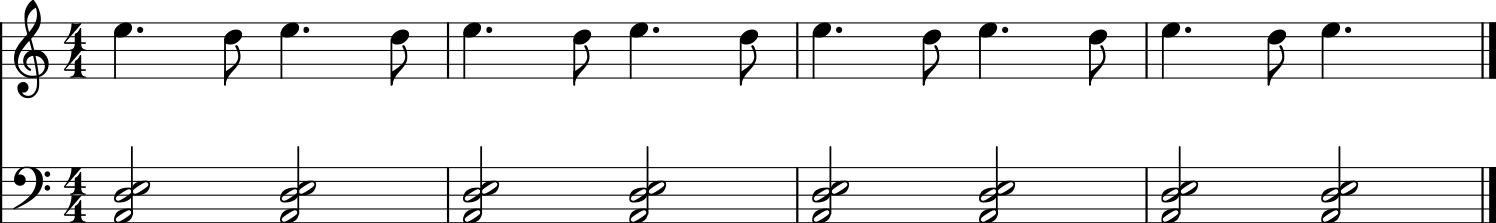

In [19]:
temp = (0.1, 0.1)
top_k = 3
top_p = 0.3

pred, full = learn.predict(item.trim_to_beat(1), n_words=100, min_bars=12, temperatures=temp, top_k=top_k, top_p=top_p)
full.split_parts().show()

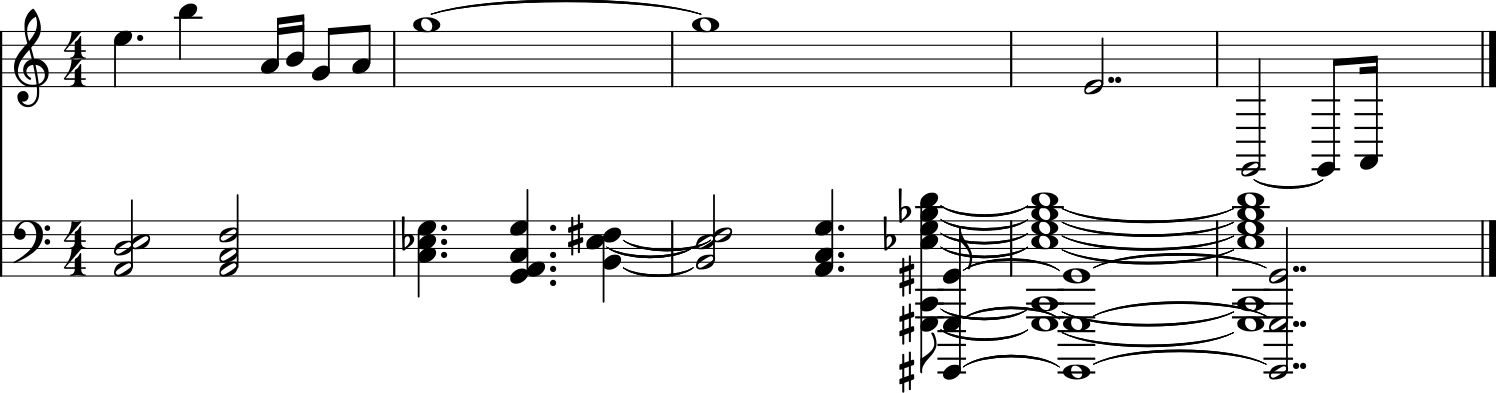

In [20]:
temp = (1.8,1.5)
top_k = 90
top_p = 0.99

pred, full = learn.predict(item.trim_to_beat(1), n_words=100, min_bars=12, temperatures=temp, top_k=top_k, top_p=top_p)
full.split_parts().show()

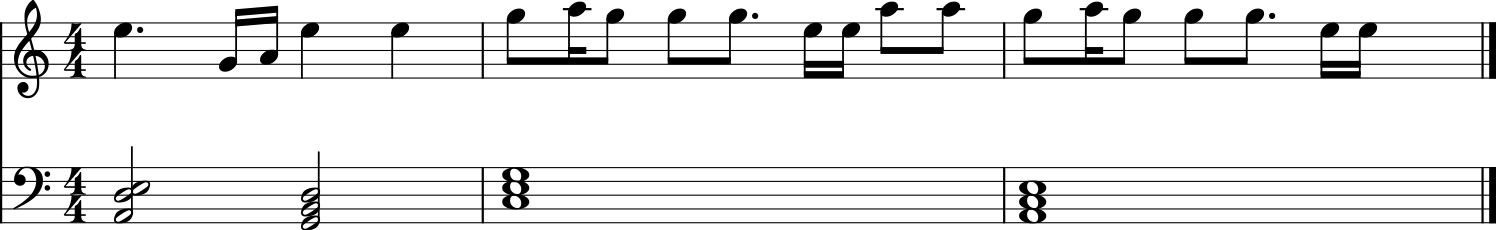

In [21]:
temp = (1.2,0.9)
top_k = 12
top_p = 0.9

pred, full = learn.predict(item.trim_to_beat(1), n_words=100, min_bars=12, temperatures=temp, top_k=top_k, top_p=top_p)
full.split_parts().show()

## Temperature / Top-K / Top-P

In [23]:
import torch
import torch.nn.functional as F
torch.set_printoptions(precision=10)

a = torch.arange(4).float()

## Temperature

T = 1

In [24]:
t_1 = F.softmax(a, dim=-1); t

tensor([0., 1., 2., 3.])

T = 0.5

In [25]:
t_05 = F.softmax(a / 0.5, dim=-1); t

tensor([0., 1., 2., 3.])

In [26]:
torch.multinomial(t_05, 8, replacement=True)

tensor([3, 2, 2, 3, 3, 3, 2, 3])

Temp = 2

In [27]:
t_2 = F.softmax(a / 2, dim=-1); t_2

tensor([0.1015363261, 0.1674050987, 0.2760043442, 0.4550542235])

In [28]:
torch.multinomial(t_2, 8, replacement=True)

tensor([2, 3, 1, 3, 3, 1, 3, 2])

## Top K

In [29]:
top_k_top_p(a, top_k=2)

tensor([-inf, -inf, 2., 3.])

In [30]:
a10 = torch.arange(10).float()
top_k_top_p(a10, top_k=2)

tensor([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, 8., 9.])

## Top P

In [31]:
# Cumulative probabilities over P are filtered out
torch.cumsum(F.softmax(a.sort(descending=True)[0], dim=-1), dim=-1)

tensor([0.6439142823, 0.8807971478, 0.9679414630, 1.0000000000])

In [32]:
top_k_top_p(a, top_p=0.65)

tensor([-inf, -inf, 2., 3.])

In [33]:
top_k_top_p(a, top_p=0.89)

tensor([-inf, 1., 2., 3.])

In [34]:
top_k_top_p(a/2, top_p=0.89)

tensor([        -inf, 0.5000000000, 1.0000000000, 1.5000000000])

#### Use seed to predict next sequence

In [13]:
pred, full = learn.predict(seed_item, n_words=400, temperatures=(1.1,0.4), min_bars=12, top_k=24, top_p=0.7)

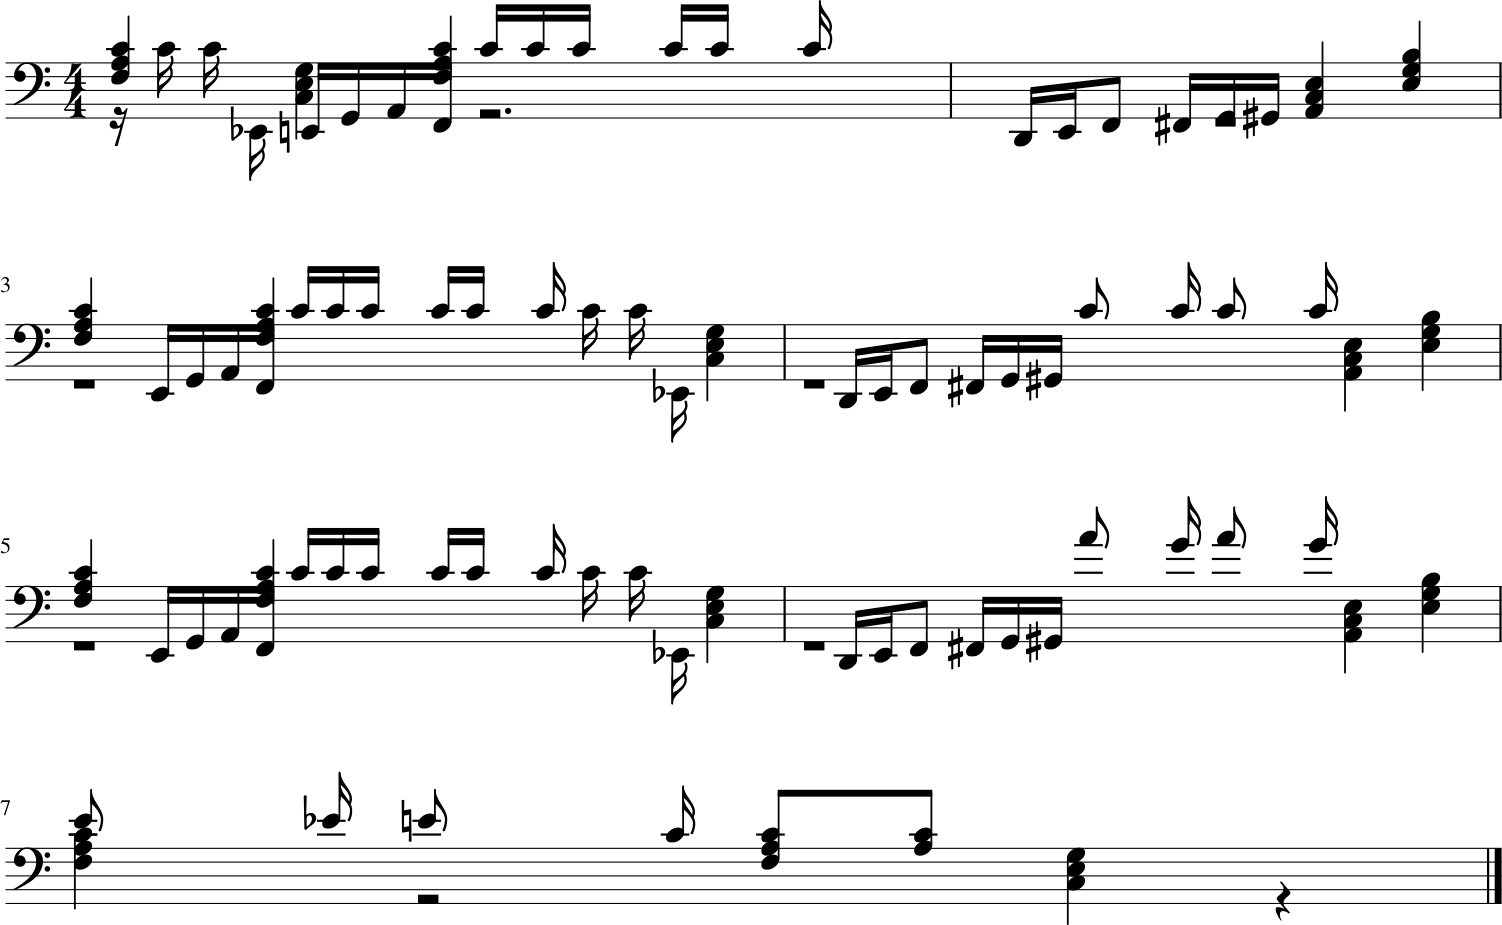

In [14]:
pred.show()

In [15]:
pred.play()

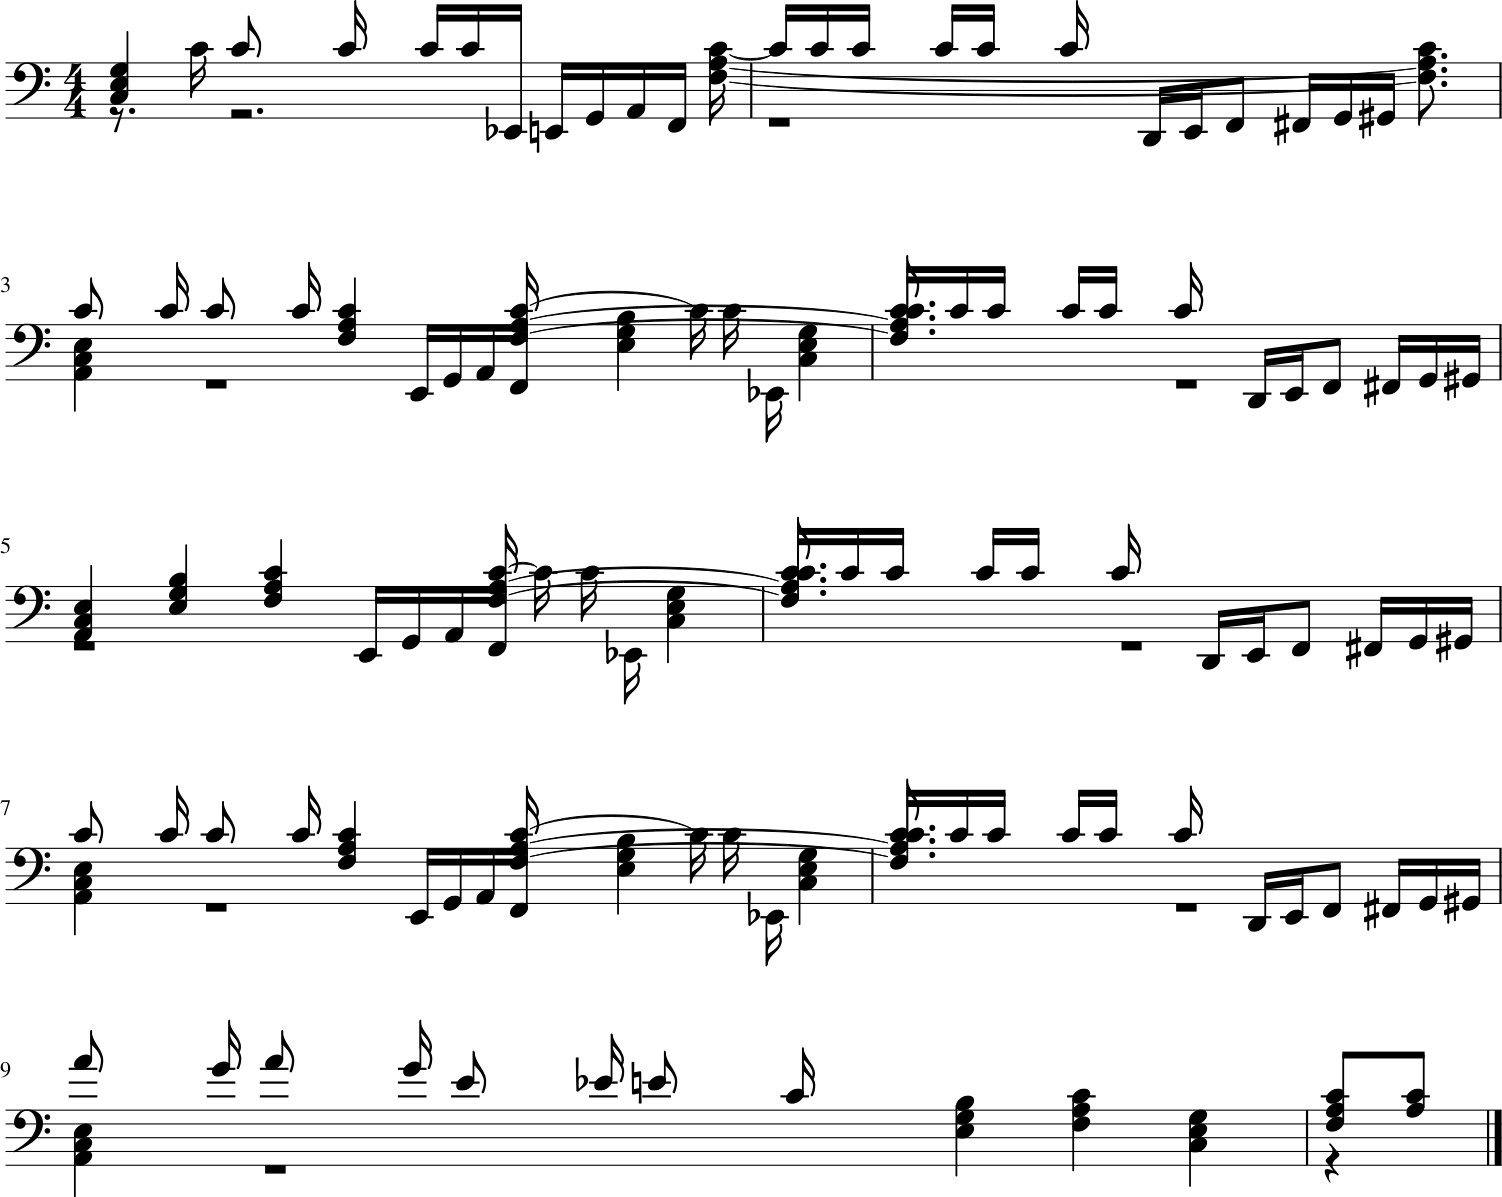

In [16]:
full_song = seed_item.append(pred); full_song.show()

In [17]:
full_song.play()

#### Add More Randomness to prediction

In [18]:
note_temp = 1.4 # Determines amount of variation in note pitches
dur_temp = 0.8 # Amount of randomness in rhythm
top_k = 30
pred, full = learn.predict(seed_item, n_words=400, temperatures=(note_temp, dur_temp), min_bars=12, top_k=top_k, top_p=0.7)

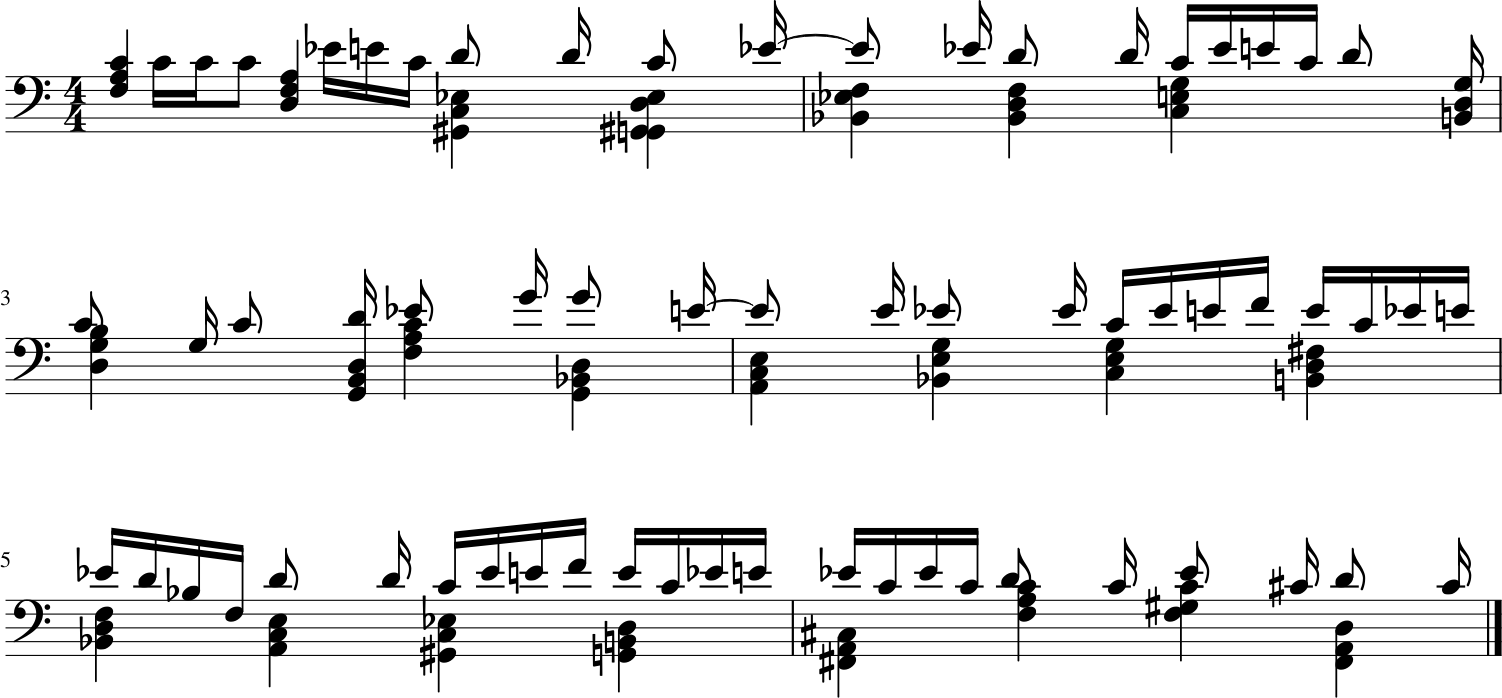

In [19]:
pred.show()

### Pop Music Theory

According to hooktheory, the most popular chord progression is I-V-vi-IV  
https://www.hooktheory.com/theorytab/common-chord-progressions

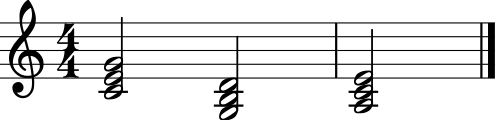

In [171]:
# Let's create a partial progression I-V-vi
p = music21.stream.Part()
p.append(music21.chord.Chord('C4 E4 G4', type='half')) # I
p.append(music21.chord.Chord('G3 B3 D4', type='half')) # V
p.append(music21.chord.Chord('A3 C4 E4', type='half')) # vi
s = music21.stream.Score([p])
chord_item = MusicItem.from_stream(s, vocab)
chord_item.show()

In [168]:
temperaturs = (0.5,0.5) # Let's lower the note randomness for this test
pred, full = learn.predict(chord_item, n_words=10, temperatures=(0.5,0.5))
full.show()

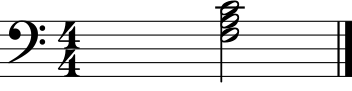

In [169]:
# Predicted chords - IV
pred.show()

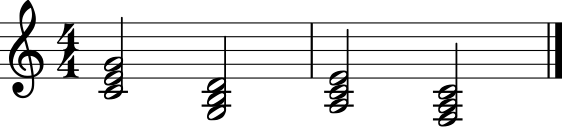

In [170]:
# Full sequence
chord_item.append(pred).show()

Looks like it predicted the most popular progression!

#### Predict without a starting sequence

In [20]:
empty_item = MusicItem.empty(vocab)

In [21]:
pred, full = learn.predict(empty_item, n_words=200)

Predicted BOS token. Returning prediction...


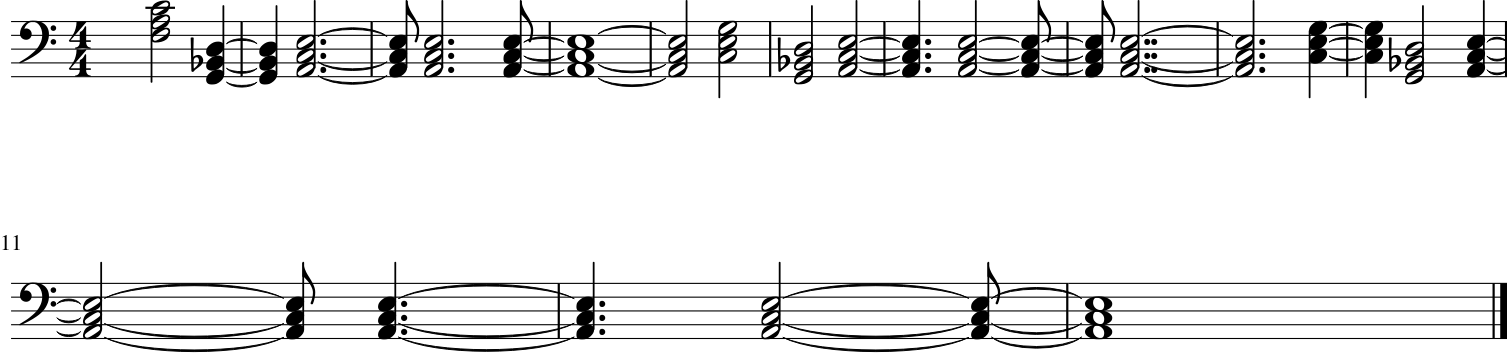

In [22]:
pred.show()